<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

C:\Users\sunitprasad\anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\sunitprasad\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\sunitprasad\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\sunitprasad\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\sunitprasad\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\sunitprasad\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.

<Figure size 720x540 with 0 Axes>

In [62]:
?dmatrices

In [3]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [4]:
bankloans.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [6]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [25]:
# ensure that you have categorical variables as strings
bankloans.ed = bankloans.ed.astype(str)
bankloans.default = bankloans.default.astype(str)

pandas_profiling.ProfileReport(bankloans)


Number of variables,9
Number of observations,850
Total Missing (%),0.0%
Total size in memory,59.8 KiB
Average record size in memory,72.1 B
Numeric,7
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [13]:
#Seperating Continuous and Categorical variables
y = bankloans.default
del bankloans["default"]

numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]

del numeric_var_names[1]
print(numeric_var_names)

cat_var_names.append("ed")
print(cat_var_names)



['age', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt']
['ed']


In [14]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

,age,employ,address,income,debtinc,creddebt,othdebt
0,41,17,12,176,9.3,11.359392,5.008608
1,27,10,6,31,17.3,1.362202,4.000798
2,40,15,14,55,5.5,0.856075,2.168925
3,41,15,14,120,2.9,2.658720,0.821280
4,24,2,0,28,17.3,1.787436,3.056564


In [15]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5)

,ed
0,3
1,1
2,1
3,1
4,2


In [16]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [17]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750


## Get training and testing

### Where ever _default_ status is missing : New set of cust : test
### Rest is training



In [31]:
y_new = y[y.isnull()==0]

In [32]:
bankloans_existing = bankloans[y.isnull()==0]
bankloans_new = bankloans[y.isnull()==1]

In [33]:
bankloans_new["default"] = y
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


In [34]:
#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [35]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x



In [36]:
bankloans_existing.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt
0,41.0,3,17.0,12.0,176.0,9.3,9.891428,5.008608
1,27.0,1,10.0,6.0,31.0,17.3,1.362202,4.000798
2,40.0,1,15.0,14.0,55.0,5.5,0.856075,2.168925
3,41.0,1,15.0,14.0,120.0,2.9,2.658720,0.821280
4,24.0,2,2.0,0.0,28.0,17.3,1.787436,3.056564


In [37]:
nums = bankloans_existing.columns.difference(other=["ed","default"])
bankloans_num = bankloans_existing[nums]
bankloans_num.corr()

,address,age,creddebt,debtinc,employ,income,othdebt
address,1.000000,0.596973,0.215397,0.014967,0.324859,0.345067,0.234896
age,0.596973,1.000000,0.308318,0.016926,0.537417,0.521450,0.348911
creddebt,0.215397,0.308318,1.000000,0.534602,0.405959,0.553114,0.639984
debtinc,0.014967,0.016926,0.534602,1.000000,-0.035332,-0.022541,0.603630
employ,0.324859,0.537417,0.405959,-0.035332,1.000000,0.665369,0.419337
income,0.345067,0.521450,0.553114,-0.022541,0.665369,1.000000,0.626787
othdebt,0.234896,0.348911,0.639984,0.603630,0.419337,0.626787,1.000000


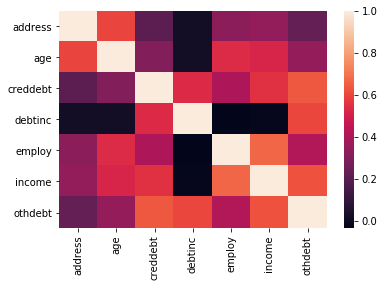

In [38]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans_num.corr())

###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

In [39]:
bankloans_existing.columns.difference(['default'])


Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

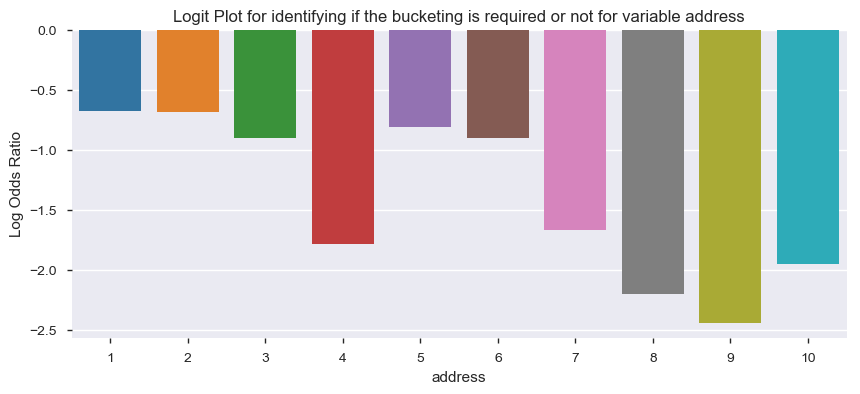

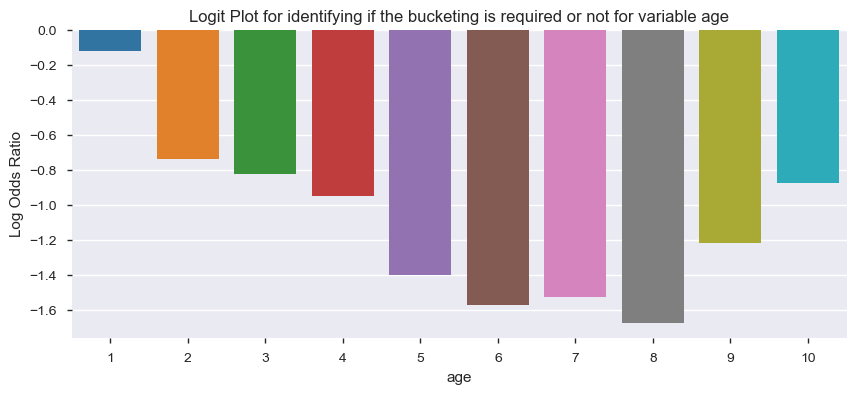

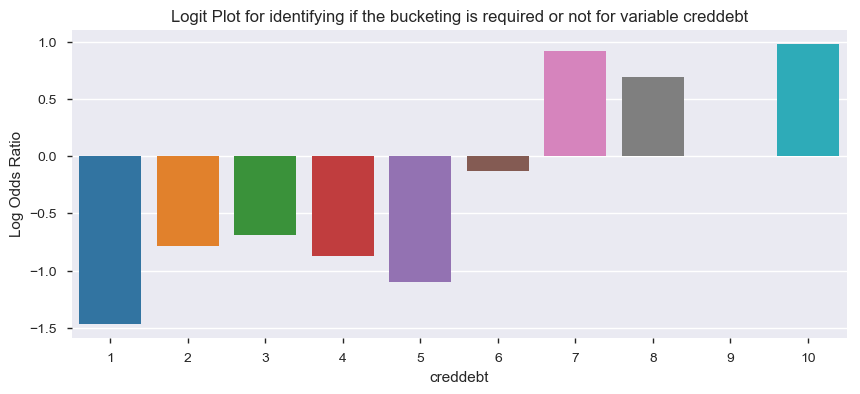

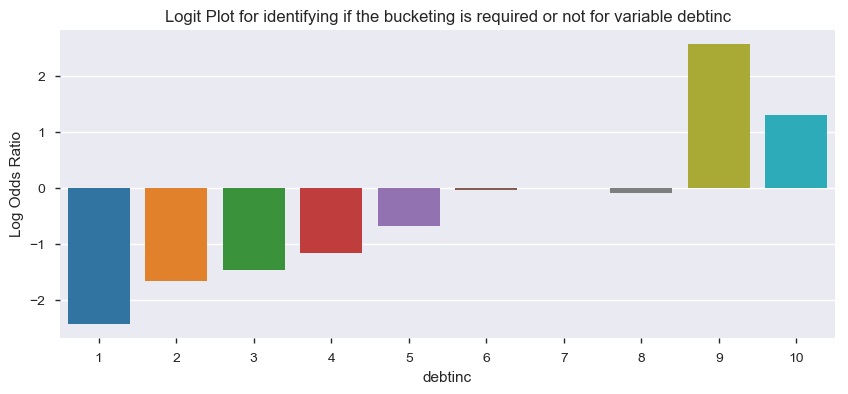

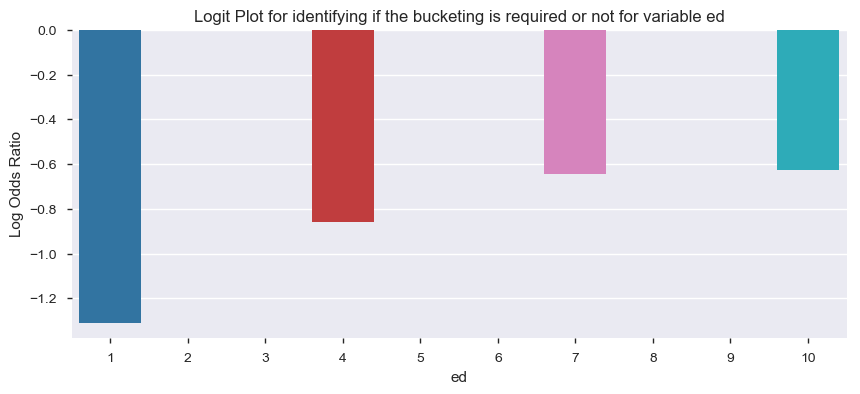

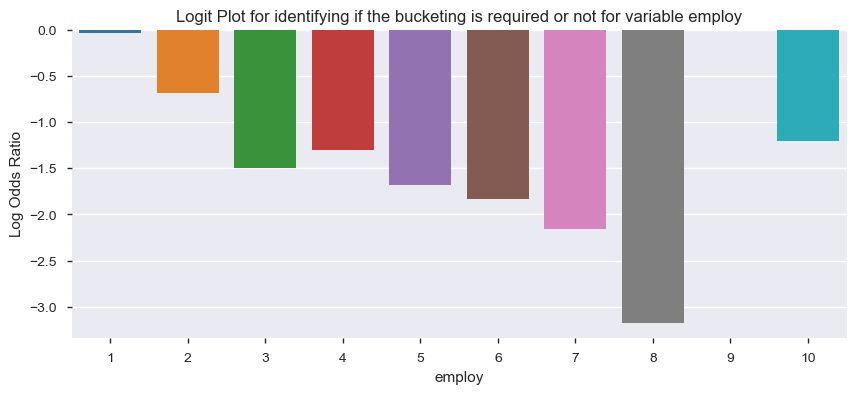

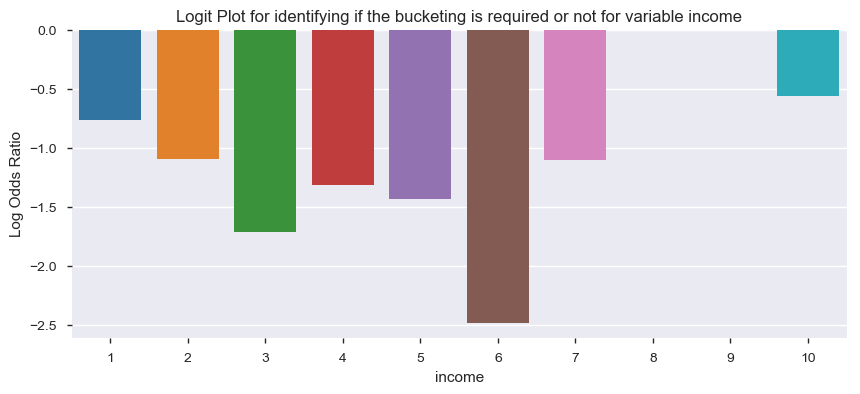

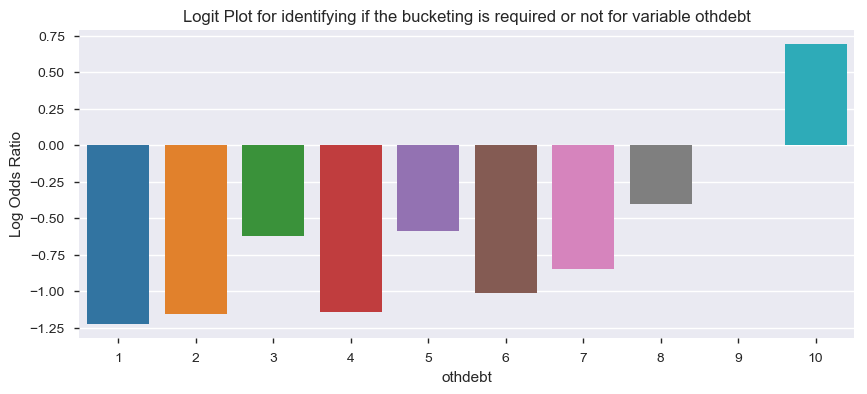

In [50]:
#Checking relation between dependent variable and Independent variable using plots
bp = PdfPages('Transformation Plots.pdf')
for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    #binned = binned.dropna()
    odds = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    log_odds = np.log(odds)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=log_odds.index,y=log_odds)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()


###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [40]:
bankloans_existing.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt'],
      dtype='object')

In [52]:
y_old = y[~y.isnull()]
bankloans_existing["default"] = y_old

In [58]:
#Conducting univarite logistic regression 
logreg_model = sm.logit('default~creddebt', data= bankloans_existing).fit()

Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5


In [59]:
#Predicting values 
p = logreg_model.predict(bankloans_existing)

In [60]:
#Calculating AUC(Area Under Curve) value
metrics.roc_auc_score(bankloans_existing['default'], p)


0.6361892380378603

In [61]:
0.76*2 - 1

0.52

In [62]:
0.81*2 - 1

0.6200000000000001

In [58]:
#SomerseD
#SomerseD = 2*AUC - 1
SomerseD = 2*metrics.roc_auc_score(bankloans_existing['default'], p)-1
SomerseD

0.27237847607572063

In [ ]:
cols = bankloans_existing.columns.difference(['default'])
model = None
pred = None
auroc = []
for col in cols:
    f = 'default ~ ' + col
    model = sm.logit(formula=f,data=bankloans_existing).fit()
    pred = model.predict(bankloans_existing)
    auroc.append(metrics.roc_auc_score(bankloans_existing['default'],pred))
cols = pd.Series(cols, name = "ColumnNames")
auroc = pd.Series(auroc,name = "auroc")


In [66]:
pd.concat([cols,auroc],axis=1).sort_values(by = "auroc",ascending=False)

,ColumnNames,auroc
3,debtinc,0.735253
5,employ,0.704569
2,creddebt,0.636189
0,address,0.611192
1,age,0.603165
6,income,0.600136
7,othdebt,0.586903
4,ed,0.574151


In [68]:
#Performing F Regression Logit or univariate Logistic regression for all variables
somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans_existing)
    result = logreg.fit()
    #summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans_existing['default'],y_score) - 1
    auroc = metrics.roc_auc_score(bankloans_existing['default'],y_score)
    temp = pd.DataFrame([num_variable,auroc]).T
    temp.columns = ['Variable Name', 'AU_ROC_Curve']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df.sort_values(["AU_ROC_Curve"],ascending=False)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,Variable Name,AU_ROC_Curve
0,debtinc,0.735253
0,employ,0.704569
0,creddebt,0.636189
0,address,0.611192
0,age,0.603165
0,income,0.600136
0,othdebt,0.586903
0,ed,0.574151


In [69]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

,address,age,creddebt,debtinc,ed,employ,income,othdebt,default
0,12.0,41.0,9.891428,9.3,3,17.0,176.0,5.008608,1.0
1,6.0,27.0,1.362202,17.3,1,10.0,31.0,4.000798,0.0
2,14.0,40.0,0.856075,5.5,1,15.0,55.0,2.168925,0.0
3,14.0,41.0,2.658720,2.9,1,15.0,120.0,0.821280,0.0
4,0.0,24.0,1.787436,17.3,2,2.0,28.0,3.056564,1.0


In [70]:
features

'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [71]:
#Calculating VIF(Variance Inflation Factor) for each variable
a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+employ', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

   VIF Factor   features
0   28.170665  Intercept
1    1.557219    address
2    1.966746        age
3    1.903500   creddebt
4    1.570261    debtinc
5    1.673062     employ


In [72]:
#Train and Test split
train, test = train_test_split(bankloans_existing, test_size=0.3, random_state=42)
train.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

### Building logistic Regression

In [85]:
logreg = sm.logit(formula='default ~ address+age+creddebt+debtinc+employ', data=train)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.427051
         Iterations 7


In [86]:
 print(result.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              430.5102  
Date:               2019-07-11 18:53 BIC:              455.6766  
No. Observations:   490              Log-Likelihood:   -209.26   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      5.6901e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7615    0.5836  -3.0185  0.0025  -2.9053  -0.6177
address       -0.0839    0.0254  -3.3047  0.0010  -0.1336  -0.0341
age            0.0392    0.0201   1.9528  0.0508  -0.0001   0.0785
creddebt       0.5996    0.103

- p = exp(LE)/(1+exp(LE))

- AIC = 2k - 2*log_liklihood
    - lower the AIC of a model, it is an indicator of a better model among multiple models
    - but still we need to check p-value of individual Betas for insignificancy
- Coefficients of significnat betas 
- Build the equation
> `LE = -1.7615 -0.0839*address+0.0392*age+0.5996*creddebt+0.0710*debtinc-0.2541*employ`


In [78]:
#AUC for both training and testing data
train_auc = metrics.roc_auc_score(train['default'], result.predict(train))
test_auc = metrics.roc_auc_score(test['default'], result.predict(test))

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)
                                 

The AUC for the model built on the Train Data is :  0.838210632232098
The AUC for the model built on the Test Data is :  0.8885790340981113


In [87]:
#GINI for training data\

# GINI = 2*AUROC -1


train_gini = 2*metrics.roc_auc_score(train['default'], result.predict(train)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)
#GINI for testing data
test_gini = 2*metrics.roc_auc_score(test['default'], result.predict(test)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.676421264464196
The Gini Index for the model built on the Test Data is :  0.7771580681962227


In [99]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's

train_predicted_prob = pd.DataFrame(result.predict(train))

train_predicted_prob.columns = ['prob']
train_actual = train['default']


# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
357,1.0,0.585803
649,0.0,0.529728
291,0.0,0.060701
420,1.0,0.599717
177,0.0,0.130221


In [100]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test))
test_predicted_prob.columns = ['prob']
test_actual = test['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.213639
500,0.0,0.462511
396,0.0,0.058998
155,0.0,0.296444
321,1.0,0.300336


In [101]:
# generates equally spaced numbers from a to b, b excluded.
# and how many numbers do you want

# in the below code generate 50 numbers from 0 to 1
# check for all those cutoffs


np.linspace(0,1,50)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [104]:
train_predict.head()
#cut-off = 0.2

,actual,prob
357,1.0,0.585803
649,0.0,0.529728
291,0.0,0.060701
420,1.0,0.599717
177,0.0,0.130221


In [105]:
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 0.0 if x < 0.2 else 1.0)

In [106]:
train_predict

,actual,prob,predicted
357,1.0,0.585803,1.0
649,0.0,0.529728,1.0
291,0.0,0.060701,0.0
420,1.0,0.599717,1.0
177,0.0,0.130221,0.0
456,0.0,0.047856,0.0
444,1.0,0.637876,1.0
83,0.0,0.296777,1.0
453,0.0,0.573234,1.0
354,1.0,0.454658,1.0


In [107]:
x = train.iloc[1:5,1:4]
x

,ed,employ,address
649,2,5.0,7.0
291,4,9.0,8.0
420,1,1.0,15.0
177,2,7.0,2.0


In [108]:
def squareall(x):
    return(x**2)

In [109]:
x.apply(squareall)

,ed,employ,address
649,4,25.0,49.0
291,16,81.0,64.0
420,1,1.0,225.0
177,4,49.0,4.0


In [110]:
x.apply(lambda v:v**2)

,ed,employ,address
649,4,25.0,49.0
291,16,81.0,64.0
420,1,1.0,225.0
177,4,49.0,4.0


In [111]:
# pred = 1 and also actiual = 1
train_predict['tp'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)

# pred = 1 but actual = 0
train_predict['fp'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)

# pred = 0 and also actiual = 0
train_predict['tn'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)

# pred = 0 but actual = 1
train_predict['fn'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)

In [112]:
train_predict.head(20)

,actual,prob,predicted,tp,fp,tn,fn
357,1.0,0.585803,1.0,1.0,0.0,0.0,0.0
649,0.0,0.529728,1.0,0.0,1.0,0.0,0.0
291,0.0,0.060701,0.0,0.0,0.0,1.0,0.0
420,1.0,0.599717,1.0,1.0,0.0,0.0,0.0
177,0.0,0.130221,0.0,0.0,0.0,1.0,0.0
456,0.0,0.047856,0.0,0.0,0.0,1.0,0.0
444,1.0,0.637876,1.0,1.0,0.0,0.0,0.0
83,0.0,0.296777,1.0,0.0,1.0,0.0,0.0
453,0.0,0.573234,1.0,0.0,1.0,0.0,0.0
354,1.0,0.454658,1.0,1.0,0.0,0.0,0.0


In [113]:
np.linspace(start=0,stop=1)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [114]:
# now we are doing the above for all the cutoffs
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [117]:
roc_like_df

,cutoff,sensitivity,specificity,accuracy,total
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.020408,1.000000,0.165730,0.393878,1.165730
0,0.040816,0.985075,0.272472,0.467347,1.257547
0,0.061224,0.970149,0.345506,0.516327,1.315655
0,0.081633,0.962687,0.387640,0.544898,1.350327
0,0.102041,0.955224,0.432584,0.575510,1.387808
0,0.122449,0.925373,0.477528,0.600000,1.402901
0,0.142857,0.925373,0.514045,0.626531,1.439418
0,0.163265,0.925373,0.561798,0.661224,1.487171
0,0.183673,0.917910,0.595506,0.683673,1.513416


In [118]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [120]:
roc_like_df.head(3)

,cutoff,sensitivity,specificity,accuracy,total
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.020408,1.000000,0.165730,0.393878,1.165730
0,0.040816,0.985075,0.272472,0.467347,1.257547


In [119]:
roc_like_df.loc[roc_like_df.total == roc_like_df.total.max() ]

,cutoff,sensitivity,specificity,accuracy,total
0,0.22449,0.858209,0.66573,0.718367,1.523939


In [121]:
#Cut-off based on highest accuracy   - some teams use this as methodology to decide the cut-off
roc_like_df[roc_like_df['accuracy']==roc_like_df['accuracy'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.530612,0.41791,0.946629,0.802041,1.36454


In [ ]:
# If sen + spec is high -- select that cutoff
# Sometimes, you can consider accuracy as well : 
# If accuracy is high -- slectec that cutoff

# If the data is proper, chances are both might lie on the same or almost close cutoff values

In [112]:
#Cut-off based on highest sensitivity
roc_like_df[roc_like_df['sensitivity']==roc_like_df['sensitivity'].max()]
# not a good judgement

,cutoff,sensitivity,specificity,accuracy,total
0,0.000000,1.0,0.00000,0.273469,1.00000
0,0.020408,1.0,0.16573,0.393878,1.16573


In [ ]:
#Choosen Best Cut-off is 0.23 based on highest (sensitivity+specicity)

In [122]:
# for training
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)

# for test for CV
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)


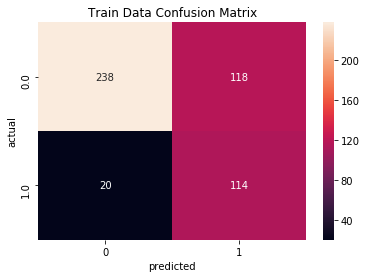

predicted,0,1
actual,,
0.0,238,118
1.0,20,114


In [126]:
confusion_matrix_train = pd.crosstab(train_predict['actual'], train_predict['predicted'])
sns.heatmap(confusion_matrix_train, annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
confusion_matrix_train

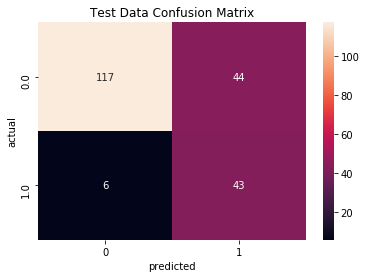

In [124]:
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()


In [127]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7183673469387755
The overall accuracy score for the Test Data  is :  0.7619047619047619


In [128]:
metrics.classification_report?

In [129]:
print(metrics.classification_report(train_predict.actual, train_predict.predicted))

             precision    recall  f1-score   support

        0.0       0.92      0.67      0.78       356
        1.0       0.49      0.85      0.62       134

avg / total       0.80      0.72      0.73       490



In [ ]:
print(metrics.classification_report(test_predict.actual, test_predict.predicted))

### Decile Analysis

In [130]:
#Decile analysis
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutin
#6th decile onwards - low risk customers - accept the applications
?pd.qcut()

In [131]:
#Decile analysis for validation of models - Business validation

In [132]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)

# 0                    100
# min(prob)            max(prob)

In [133]:
train_predict.head()

,actual,prob,predicted,tp,fp,tn,fn,Deciles
357,1.0,0.585803,1,1.0,0.0,0.0,0.0,8
649,0.0,0.529728,1,0.0,1.0,0.0,0.0,8
291,0.0,0.060701,0,0.0,0.0,1.0,0.0,2
420,1.0,0.599717,1,1.0,0.0,0.0,0.0,8
177,0.0,0.130221,0,0.0,0.0,1.0,0.0,3


In [134]:
test_predict['Deciles']=pd.qcut(test_predict['prob'],10, labels=False)
test_predict.rename(columns={"actual":"actual_from_test","prob":"prob_test"})
test_predict.head()

,actual,prob,predicted,Deciles
158,1.0,0.213639,0,5
500,0.0,0.462511,1,7
396,0.0,0.058998,0,2
155,0.0,0.296444,1,6
321,1.0,0.300336,1,6


In [121]:

# Decile Analysis for train data

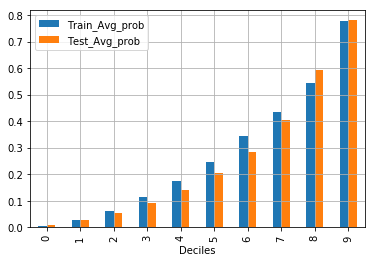

In [135]:
#----------------------
no_1s = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)['actual']

#----------------------
max_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).min().sort_index(ascending=False)['prob']

#----------------------
train_dec = train_predict.groupby("Deciles")[["prob"]].mean().add_prefix("Train_Avg_")
test_dec = test_predict.groupby("Deciles")[["prob"]].mean().add_prefix("Test_Avg_")

Final_Deciles = pd.concat([train_dec,test_dec],axis=1)
Final_Deciles.plot(kind = "bar")

In [136]:
Decile_analysis_train = pd.concat([max_prob], axis=1)

In [137]:
Decile_analysis_train

,prob
Deciles,
9,0.986816
8,0.625658
7,0.491821
6,0.396070
5,0.288422
4,0.211515
3,0.143758
2,0.083720
1,0.040588


In [138]:
# Decile Analysis for train data

no_1s = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).min().sort_index(ascending=False)['prob']

Decile_analysis_test = pd.concat([min_prob], axis=1)

Decile_analysis_test

,prob
Deciles,
9,0.677376
8,0.491667
7,0.320771
6,0.254996
5,0.168005
4,0.117243
3,0.066399
2,0.040592
1,0.017485


In [139]:
Decile_analysis_train.to_csv('Decile_analysis_train.csv')

In [140]:
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

## Predicting new customers (Implementation of Model on new data)

In [ ]:
# predciting new customers good or bad
bankloans_new.head()

In [ ]:
#before scoring new customers, you need to process the data using the sames steps you followed while building the model
#Excercise


In [ ]:
#Predicting values for bankloans_new data
bankloans_new['prob'] = result.predict(bankloans_new)

In [ ]:
bankloans_new.head()

In [ ]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)

In [ ]:
bankloans_new.head()

In [ ]:
bankloans_new.default.value_counts()

In [ ]:
#We are rejecting applications for ~60 customers based on cut-off = 0.23